### First test code for 40mhz Domesday Duplicator samples.  (so far so good!)

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

In [2]:
pi = np.pi
tau = np.pi * 2

# Make sure this is a power of two!
blocklenk = 1024
blocklen = (blocklenk * 1024)

In [257]:
def dosplot(B, A, freq = (315.0/88.0) * 8.0):
	w, h = sps.freqz(B, A)

	fig = plt.figure()
	plt.title('Digital filter frequency response')

	ax1 = fig.add_subplot(111)

	db = 20 * np.log10(abs(h))

	for i in range(1, len(w)):
		if (db[i] >= -10) and (db[i - 1] < -10):
			print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] >= -3) and (db[i - 1] < -3):
			print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] < -3) and (db[i - 1] >= -3):
			print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] < -10) and (db[i - 1] >= -10):
			print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] < -20) and (db[i - 1] >= -20):
			print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

	plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
	plt.ylabel('Amplitude [dB]', color='b')
	plt.xlabel('Frequency [rad/sample]')

	plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
	w, h = sps.freqz(B, A)

	fig = plt.figure()
	plt.title('Digital filter frequency response')
	
	db = 20 * np.log10(abs(h))
	for i in range(1, len(w)):
		if (db[i] >= -10) and (db[i - 1] < -10):
			print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] >= -3) and (db[i - 1] < -3):
			print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
		if (db[i] < -3) and (db[i - 1] >= -3):
			print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

	ax1 = fig.add_subplot(111)
	
	plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
	plt.ylabel('Amplitude [dB]', color='b')
	plt.xlabel('Frequency [rad/sample]')

	ax2 = ax1.twinx()
	angles = np.unwrap(np.angle(h))
	plt.plot(w * (freq/pi) / 2.0, angles, 'g')
	plt.ylabel('Angle (radians)', color='g')
	
	plt.grid()
	plt.axis('tight')
	plt.show()

def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
	w, h = sps.freqz(B, A)
	w2, h2 = sps.freqz(B2, A2)

#	h.real /= C
#	h2.real /= C2

	begin = 0
	end = len(w)
#	end = int(len(w) * (12 / freq))

#	chop = len(w) / 20
	chop = 0
	w = w[begin:end]
	w2 = w2[begin:end]
	h = h[begin:end]
	h2 = h2[begin:end]

	v = np.empty(len(w))
	
#	print len(w)

	hm = np.absolute(h)
	hm2 = np.absolute(h2)

	v0 = hm[0] / hm2[0]
	for i in range(0, len(w)):
#		print i, freq / 2 * (w[i] / pi), hm[i], hm2[i], hm[i] / hm2[i], (hm[i] / hm2[i]) / v0
		v[i] = (hm[i] / hm2[i]) / v0

	fig = plt.figure()
	plt.title('Digital filter frequency response')

	ax1 = fig.add_subplot(111)

	v  = 20 * np.log10(v )

#	plt.plot(w * (freq/pi) / 2.0, v)
#	plt.show()
#	exit()

	plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
	plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
	plt.ylabel('Amplitude [dB]', color='b')
	plt.xlabel('Frequency [rad/sample]')
	
	ax2 = ax1.twinx()
	angles = np.unwrap(np.angle(h))
	angles2 = np.unwrap(np.angle(h2))
	plt.plot(w * (freq/pi) / 2.0, angles, 'g')
	plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
	plt.ylabel('Angle (radians)', color='g')

	plt.grid()
	plt.axis('tight')
	plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])


In [3]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,
    'audio_filtwidth': 200000,
    'audio_filtorder': 1,

    'fsc_mhz': (315.0 / 88.0),

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # changeable defaults
    #'deemp': (120, 320), # actual deemp timing
    'deemp': (135, 320),

    'vbpf': (3200000, 14000000),
    'vbpf_order': 1,
    
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 4 # butterworth filter order
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [4]:
# Domesday Duplicator system uses 32mhz/10bit, expressed as 16-bit signed integers
CapParams_DomesdayDuplicator = {
    'freq': 40.0,
    'dtype': np.int16,
}

# cxadc can only really capture at 8fsc (28.8xmhz), with 8-bit unsigned samples
CapParams_cxadc = {
    'freq': (315.0 / 88.0) * 8.00,
    'dtype': np.uint8,
}

try:
    tmp = CapParams['freq']
except:
    CapParams = CapParams_cxadc

In [5]:
CapParams = CapParams_cxadc
CapParams = CapParams_DomesdayDuplicator
SysParams = copy.deepcopy(SysParams_NTSC)

In [6]:
SysParams['vsync_freq'] = 1000000
SysParams['vsync_order'] = 3

In [7]:
OverrideParams = {}

params = {}

for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
audio_filtwidth 200000
audio_filtorder 1
fsc_mhz 3.5795454545454546
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (135, 320)
vbpf (3200000, 14000000)
vbpf_order 1
vlpf_freq 4200000
vlpf_order 4
vsync_freq 1000000
vsync_order 3
freq 40.0
dtype <class 'numpy.int16'>


In [76]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
    #np.fft.ifft([0]+[1]*(blocklen//4)+[0]*(blocklen//4))
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

# A rather pants attempt at doing an MTF function. This needs to be better.
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(SP):
    SP['freq_hz'] = SP['freq'] * 1000000
    
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'))

    # post-demod deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp']

In [100]:
# The actual video demodulation code
def dodemod(params, data, clip = None, usemtf = False, cutarf = False):
    prepare_video_filters(params)

    data_fft = np.fft.fft(data)
    
    datac = data_fft * params['FRFVideo']
    if usemtf is True:
        datac *= Fmtf
    
    hilbert = np.fft.ifft(datac * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
            dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    demod = (tdangles2 * (params['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)

    # note: imaginary component of this ifft is virtually zero
    output = np.fft.ifft(demod_fft * params['FVideo']).real
    
    return output


In [101]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [102]:
prepare_video_filters(params)

In [103]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    print(20 * np.log10(100 / stdire))

In [1178]:
#infile = open('.raw', 'rb')
infile = open('/home/cpage/rotplane40_30.raw', 'rb')
inbuf = infile.read(1024 * 1024 * 8)
indata1 = np.fromstring(inbuf, 'int16', len(inbuf) // 2)

data1 = indata1[0:blocklen]
#data2 = indata1[blocklen:blocklen*2]


In [1179]:
blockcut = 1024

SysParams = copy.deepcopy(SysParams_NTSC)
params = {}

In [1180]:
for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        #print(k, p[k])
        params[k] = p[k]

        adj = 1
params['deemp'] = [120*adj, 320*adj]
params['vbpf'] = (3500000, 14000000)
params['vbpf_order'] = 6

params['ahpf_freq'] = 3100000
params['ahpf_order'] = 2

params['vlpf_freq'] = 4200000
params['vlpf_order'] = 5

output1 = dodemod(copy.deepcopy(params), data1, usemtf=False)
#calcsnr(output1[214400:215500]), calcsnr(output1[217000:218000]), calcsnr(output1[213820:213950])
calcsnr(output1[156000:157000]), calcsnr(output1[169100:169500])

18.3756333143
19.1975410938


(None, None)

In [1181]:
def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

12.6537692579
8.65216754867


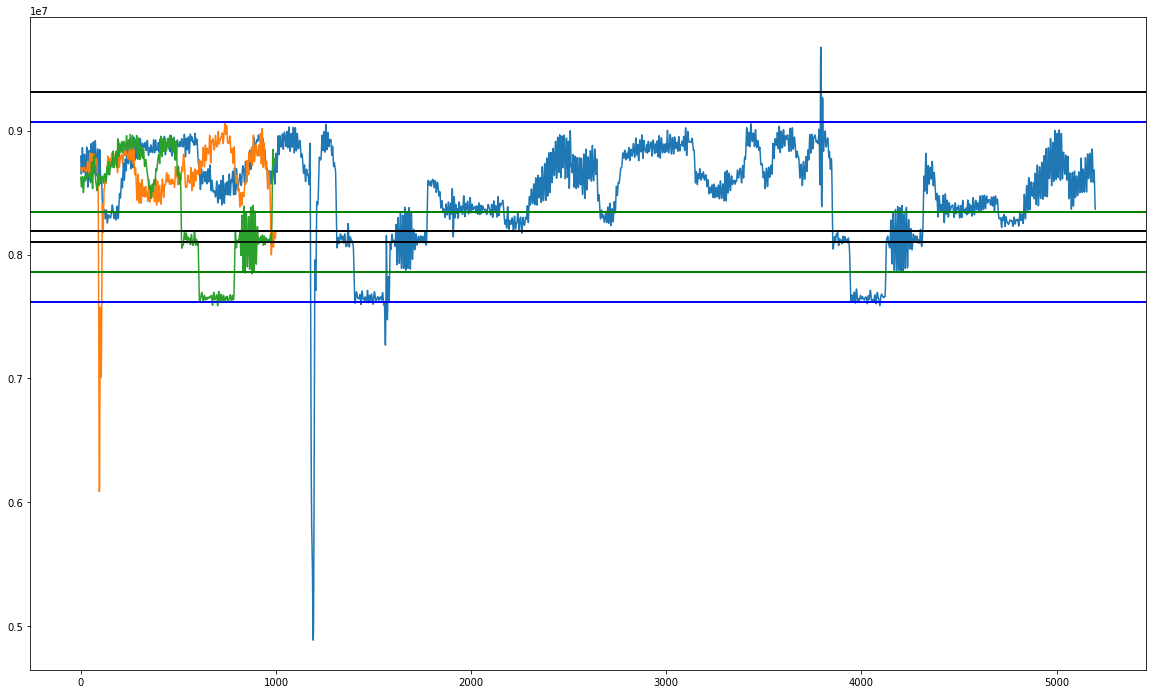

In [1182]:
for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        #print(k, p[k])
        params[k] = p[k]

adj = .7
params['deemp'] = [120*adj, 320*adj]
params['vbpf'] = (3500000, 14000000)
params['vbpf_order'] = 3

params['audio_filtwidth'] = 150000
params['audio_filtorder'] = 1

params['vlpf_freq'] = 4200000
params['vlpf_order'] = 5

output1 = dodemod(copy.deepcopy(params), data1, usemtf=False)

lineplot(output1[219500:224700], params)
lineplot(output1[199500:200500], params)
lineplot(output1[202500:203500], params)
calcsnr(output1[199500:200500])
calcsnr(output1[202500:203500])

In [1183]:
# The actual video demodulation code

#def dodemod(params, data, clip = None, usemtf = False, cutarf = False):
paramsc = copy.deepcopy(params)

ptr = 1024 * 800
data1 = indata1[ptr:ptr + blocklen]

prepare_video_filters(paramsc)

indata_fft = np.fft.fft(data1)
indata_fft_filt = indata_fft * paramsc['FRFVideo']

#indata_filt = np.fft.ifft(indata_fft_filt)
hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

tangles = np.angle(hilbert)
dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

# make sure unwapping goes the right way
if (dangles[0] < -pi):
    dangles[0] += tau

tdangles2 = np.unwrap(dangles) 
demod = (tdangles2 * (paramsc['freq_hz'] / tau))

demod_fft = np.fft.fft(demod)
output = np.fft.ifft(demod_fft * paramsc['FVideo']).real


In [1184]:
rfsync_filt = filtfft(sps.butter(1, [(7.55)/freq_half, (7.65)/freq_half], btype='bandpass'))
dsync = sqsum(np.fft.ifft(indata_fft * rfsync_filt * fft_hilbert))

rfsync_filta = sps.firwin(513, [7.55/freq_half, 7.65/freq_half], pass_zero=False)
rfsync_filta = sps.firwin(1025, [7.575/freq_half, 7.625/freq_half], pass_zero=False)
dsync2 = sqsum(np.fft.ifft(indata_fft * filtfft((rfsync_filta, [1.0])) * fft_hilbert))

In [1185]:
tmp = filtfft([sps.firwin(65, 0.1/freq_half, pass_zero=True), [1.0]])
dsync2a = np.fft.ifft(np.fft.fft(dsync2) * tmp).real


#cburst_filta = sps.firwin(129, [(paramsc['fsc_mhz'] - .05)/freq_half, (paramsc['fsc_mhz'] + .05)/freq_half], pass_zero=False)
#dsync2 = sqsum(np.fft.ifft(indata_fft * filtfft((cburst_filta, [1.0])) * fft_hilbert))

rf0_filt = filtfft(sps.butter(4, [(8.05)/freq_half, (8.15)/freq_half], btype='bandpass'))
d0 = sqsum(np.fft.ifft(indata_fft * rf0_filt * fft_hilbert))

dsync[1000:4000].argmax(), dsync2[1000:4000].argmax()

(1018, 1433)

In [1186]:
np.where(dsync2[0:5000] > 250)[0][0]

2079

In [1187]:
(freq_hz_half * 2) / (1000000 / 63.35)

2534.0

In [1188]:
# one pass at a sync det...

p = 0
syncs = []
while p < len(dsync2):
    locs = np.where(dsync2[p+0:p+2600] > 250)[0]
    if len(locs) >= 1:
        print(p + locs[0], dsync2[p + locs[0]], )
        syncs.append(p + locs[0])

        p += locs[0]
        
        is_vsync = np.sum(dsync2[p:p + 800] > 1500) > 0
        
        if is_vsync:
            print('vs')
            locs_down = np.where(dsync2[p+800:p+10000] < 800)[0]
        else:
            locs_down = np.where(dsync2[p+0:p+800] < 250)[0]
            
        if len(locs_down) >= 1:
            print(p, locs_down[0], np.max(dsync2[p:p+400]))
            p += locs_down[0]
            if is_vsync:
                p += 800
        else:
            if np.sum(dsync2[p:p + 800] > 1500) > 0:
                print('vsync')
            p += 1000
    else:
        p += 2600
    

2079 251.562868335
2079 686 955.908000277
4626 251.448270669
4626 678 941.623899154
7170 251.708552995
7170 677 945.584939696
9717 251.397710206
9717 661 926.662031063
12263 251.070292099
12263 665 924.06188664
14796 250.852026964
14796 671 944.948534268
17348 252.189925065
17348 662 931.662876935
19889 250.07839644
19889 670 939.170146335
22441 250.763682282
22441 654 898.949327988
24979 251.155164527
24979 664 911.223790927
27526 252.025713217
27526 667 934.371545018
30075 252.299212082
30075 663 927.107150321
32611 251.31789796
32611 664 940.930804939
35158 251.343213577
35158 667 919.595517
37706 251.180656432
37706 656 916.642631437
40248 251.246935667
40248 665 920.431094998
42797 250.981242477
42797 664 913.660062812
45332 250.262373248
45332 661 916.520849396
47876 250.485767301
47876 661 929.887446747
50421 251.782502195
50421 661 917.219200077
52963 250.765503159
52963 675 941.767894702
55496 251.143843423
55496 683 940.846932134
58048 250.642394022
58048 662 923.038471193
60

574233 250.685628419
574233 668 936.624902001
576761 250.918729845
576761 674 939.279815636
579318 251.519199535
579318 662 913.160673424
581856 251.551863494
581856 656 881.442516552
584447 250.072907631
584447 567 622.851447149
589772 251.646005745
589772 557 602.16775103
592272 250.278187565
592272 647 866.642433292
594799 251.530683091
594799 666 909.628514147
597350 250.408200532
597350 654 903.129958711
599886 251.460521404
599886 663 900.765555897
602435 252.052230771
602435 655 902.296800578
604981 251.085420848
604981 650 876.547109002
607515 251.821199218
607515 654 893.562254979
610064 251.39985111
610064 652 886.168908867
612613 250.27233167
612613 675 932.437760185
615146 250.361257226
615146 654 887.734807998
617695 252.04219717
617695 662 900.515042533
620224 250.347076744
620224 675 907.154679719
622758 251.026779115
622758 674 927.158908273
625306 250.331024933
625306 666 914.053556959
627851 250.598927007
627851 665 912.653582233
630403 250.786146744
630403 653 896.02

In [1189]:
syncs = np.where((dsync2a[:-1] > dsync2a[1:])[1:] & (dsync2a[1:] > dsync2a[:-1])[:-1] & (dsync2a[:-2] > 250)) 
# & (dsync2a[:-2] > 100))

In [1190]:
dsync2a[syncs]

array([  954.43438095,   940.09986826,   942.93555162,   924.68280346,
         922.51545473,   943.05829657,   929.67950002,   937.43130549,
         897.20031063,   909.26617215,   932.30158666,   924.40844932,
         938.7803719 ,   917.89288791,   914.35501437,   917.51139413,
         911.61114693,   913.26509853,   926.55597583,   914.00828376,
         938.52218401,   938.38820846,   921.86758664,   940.11692526,
         932.0127086 ,   933.39655522,   927.57938634,   867.96216995,
         930.31741663,   874.04195185,   928.40521922,   936.58652068,
         936.7033941 ,   919.36098012,   934.95155684,   926.83950628,
         945.43552577,   942.5647085 ,   928.43813991,   937.4365243 ,
         935.02233889,   936.97725267,   944.20610469,   931.75584697,
         938.8646586 ,   933.70350188,   921.73028436,   943.647465  ,
         933.77769967,   935.19901474,   946.49056667,   937.03475122,
         942.55663076,   917.10574884,   879.57045463,   866.50990427,
      

In [1191]:
(freq_hz_half * 2) * (27 / 1000000)

1080.0

In [1192]:
# the filter width here should be approximately 27usec, so the 1.0 peak is in the vsync signals
# (but this takes too long to compute!)
#synclpf = filtfft((sps.firwin(1081, 0.1/freq_hz_half, pass_zero=True),[1.0]))

In [1193]:
(freq_hz_half * 2) * (9.4 / 1000000)

376.0

In [1194]:
synclpf = filtfft((sps.firwin(377, 0.1/freq_hz_half, pass_zero=True),[1.0]))

In [1195]:
# emperical work determined that a single-pole low frequency filter effectively 
# detects the end of a (regular) sync pulse.  peak levels determine which type 
# of sync pulse.

# A regular pulse should peak around .8, a half pulse around .5-.6, and a vsync pulse ~1 (with fake peaks, bottom ~.2)

f = sps.butter(1, 0.05/freq_half, btype='low')
synclpfb = filtfft(f)

In [1196]:
output_sync = (output > (params['videorf_0ire'] + (params['hz_ire'] * -60))) & (output < (params['videorf_0ire'] + (params['hz_ire'] * -30)))

output_syncf = np.fft.ifft(np.fft.fft(output_sync) * synclpfb).real

In [1197]:
np.max(output_syncf)

0.99984648169321633

In [1198]:
syncs = np.where((output_syncf[:-1] > output_syncf[1:])[1:] & (output_syncf[1:] > output_syncf[:-1])[:-1] & (output_syncf[:-2] > 0.46) & (output_syncf[:-2] < 0.85)) 

In [1199]:
syncs = np.where((output_syncf[:-1] < output_syncf[1:])[1:] & (output_syncf[1:] < output_syncf[:-1])[:-1] & (output_syncf[:-2] < 0.15)) 

In [1200]:
s = ((output_syncf[:-1] < output_syncf[1:])[1:] & (output_syncf[1:] < output_syncf[:-1])[:-1] & (output_syncf[:-2] < 0.15)) 

In [1201]:
syncs1 = np.diff(output_syncf > .1)
syncs2 = np.diff(output_syncf > .2)

In [1202]:
pulses = [-1]

for z in zip(np.where(syncs2)[0][1:], np.diff(np.where(syncs2)[0])):
    #print(z)
    if (z[0] > 500) & (z[1] < 500):
        subset = output_syncf[z[0]-500:z[0]]
        #print(np.max(subset), np.argmax(subset) + z[0] - 500)
        peakloc = np.argmax(subset) + z[0] - 500
        if output_syncf[peakloc] > .4 and peakloc != pulses[-1]:
            pulses.append(np.argmax(subset) + z[0] - 500)

In [1203]:
pulses

[-1,
 2024,
 4568,
 7111,
 9654,
 12199,
 14742,
 17286,
 19829,
 22348,
 24915,
 27460,
 30004,
 32546,
 35091,
 37635,
 40179,
 42722,
 45266,
 47809,
 50350,
 52896,
 55440,
 57984,
 60527,
 63071,
 65615,
 68159,
 70703,
 73246,
 75790,
 78333,
 80877,
 83421,
 85964,
 88507,
 91052,
 93594,
 96138,
 98681,
 101226,
 103769,
 106312,
 108856,
 111399,
 113944,
 116486,
 119030,
 121573,
 124116,
 126660,
 129203,
 131746,
 134291,
 136834,
 139377,
 141920,
 144463,
 147006,
 149550,
 152093,
 154637,
 157180,
 159722,
 162267,
 164810,
 167352,
 169895,
 172439,
 174982,
 177525,
 180068,
 182611,
 185154,
 187698,
 190241,
 192783,
 195327,
 197870,
 200413,
 202957,
 205500,
 208043,
 210586,
 213129,
 215672,
 218215,
 220758,
 223301,
 225844,
 228387,
 230931,
 233473,
 236017,
 238559,
 241102,
 243646,
 246188,
 248732,
 251275,
 253818,
 256361,
 258904,
 261448,
 263990,
 266533,
 269075,
 271620,
 274162,
 276705,
 279248,
 281791,
 284334,
 286877,
 289419,
 291962,
 29

In [1204]:
img = np.zeros((2500 * 525), dtype=np.uint16)

In [1205]:
# old lddecode format
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [1206]:
reduced = (output - minn) / hz_ire_scale
output_u16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

In [1207]:
lines = np.zeros((525 * 2500), dtype=np.uint16)

In [1208]:
lines

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [1209]:
output_u16[z[1]:z[1] + 2500]

array([25621, 25365, 25177, ..., 23836, 23885, 23754], dtype=uint16)

In [1210]:
l = 0
for z in zip(np.diff(pulses), pulses):
    if (z[0] > 2500) and z[0] < 2580:
        print(z, output_syncf[z[1]])
        lines[l*2500:(l + 1) * 2500] = output_u16[z[1]:z[1] + 2500]
        l += 1
        if l >= 525:
            break

(2544, 2024) 0.753881586649
(2543, 4568) 0.753881568654
(2543, 7111) 0.753881568667
(2545, 9654) 0.753881568667
(2543, 12199) 0.755807026934
(2544, 14742) 0.753882342983
(2543, 17286) 0.755807026947
(2519, 19829) 0.753881568671
(2567, 22348) 0.702860545611
(2545, 24915) 0.751941038678
(2544, 27460) 0.75580702693
(2542, 30004) 0.755807026951
(2545, 32546) 0.751940928804
(2544, 35091) 0.753881568638
(2544, 37635) 0.757732589996
(2543, 40179) 0.75771742181
(2544, 42722) 0.755807026967
(2543, 45266) 0.755807136843
(2541, 47809) 0.753881572987
(2546, 50350) 0.749984985757
(2544, 52896) 0.753881568621
(2544, 55440) 0.751940928149
(2543, 57984) 0.75388156865
(2544, 60527) 0.753881568667
(2544, 63071) 0.755807027257
(2544, 65615) 0.755809823369
(2544, 68159) 0.755834759668
(2543, 70703) 0.636903096063
(2544, 73246) 0.755821157396
(2543, 75790) 0.766019030918
(2544, 78333) 0.753881568692
(2544, 80877) 0.755807026947
(2543, 83421) 0.755856964853
(2543, 85964) 0.753881568671
(2545, 88507) 0.75388

In [1211]:
l*2500

627500

In [1212]:
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2500, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

(1312500,)
uint8 (525, 2500) (525, 2500)


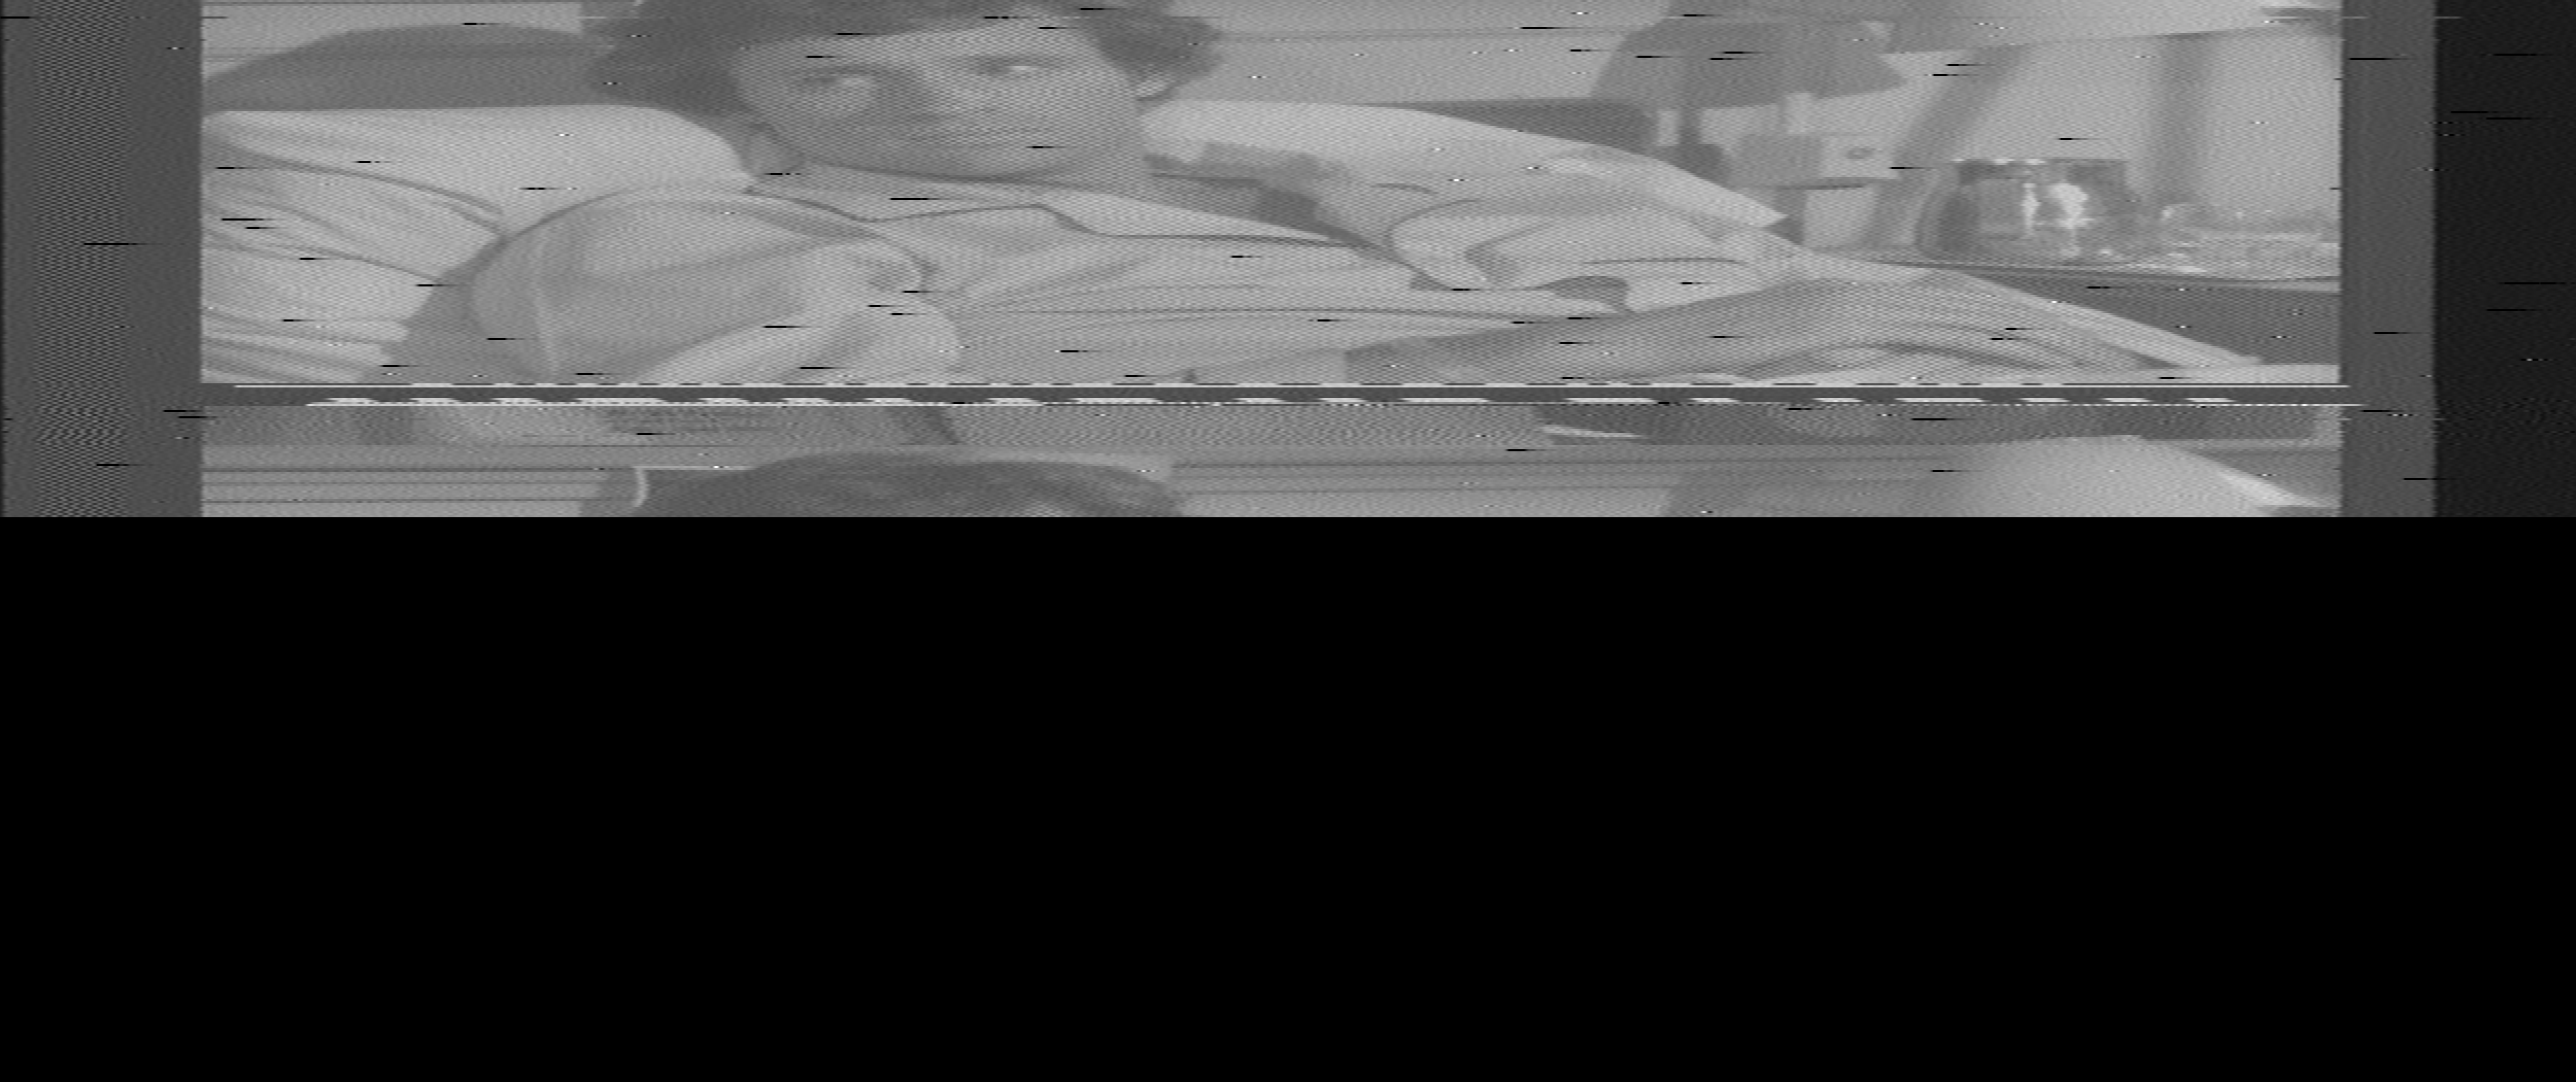

In [1213]:
drawdata(lines, hscale=2, vscale=4)

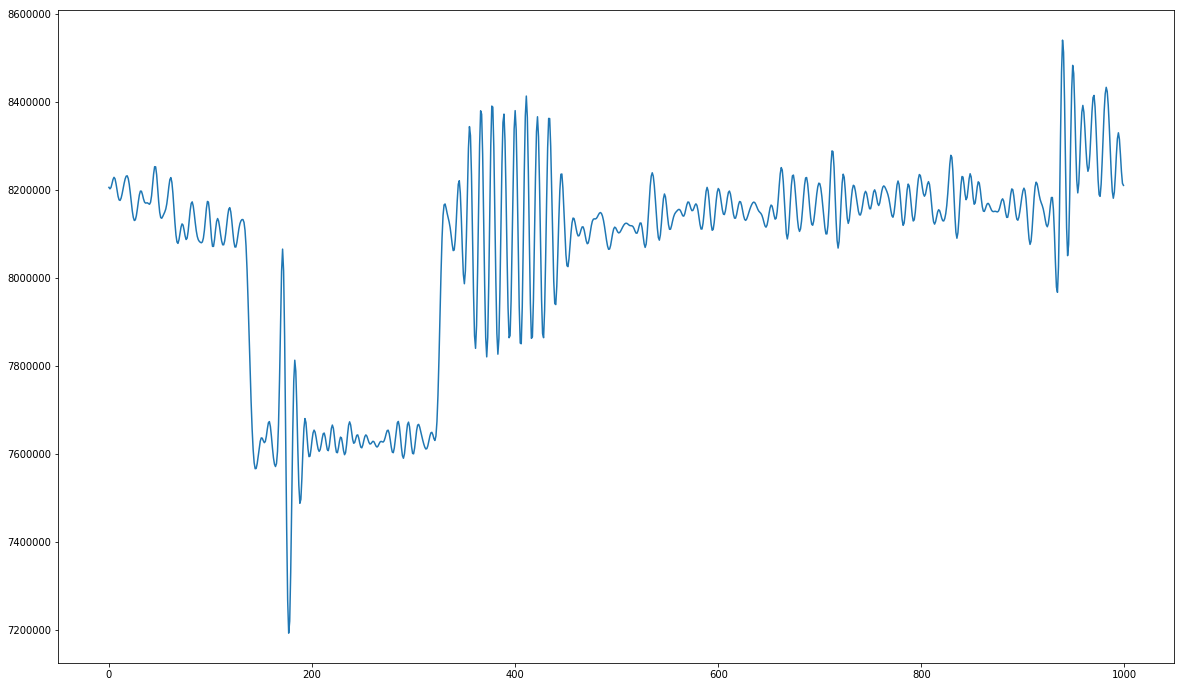

In [1044]:
plt.plot(output[599000:600000])

In [1003]:
syncs1 = np.where((output_syncf[:-1] <= .1) & (output_syncf[1:] > .1))
syncs2 = np.where((output_syncf[:-1] <= .2) & (output_syncf[1:] > .2))

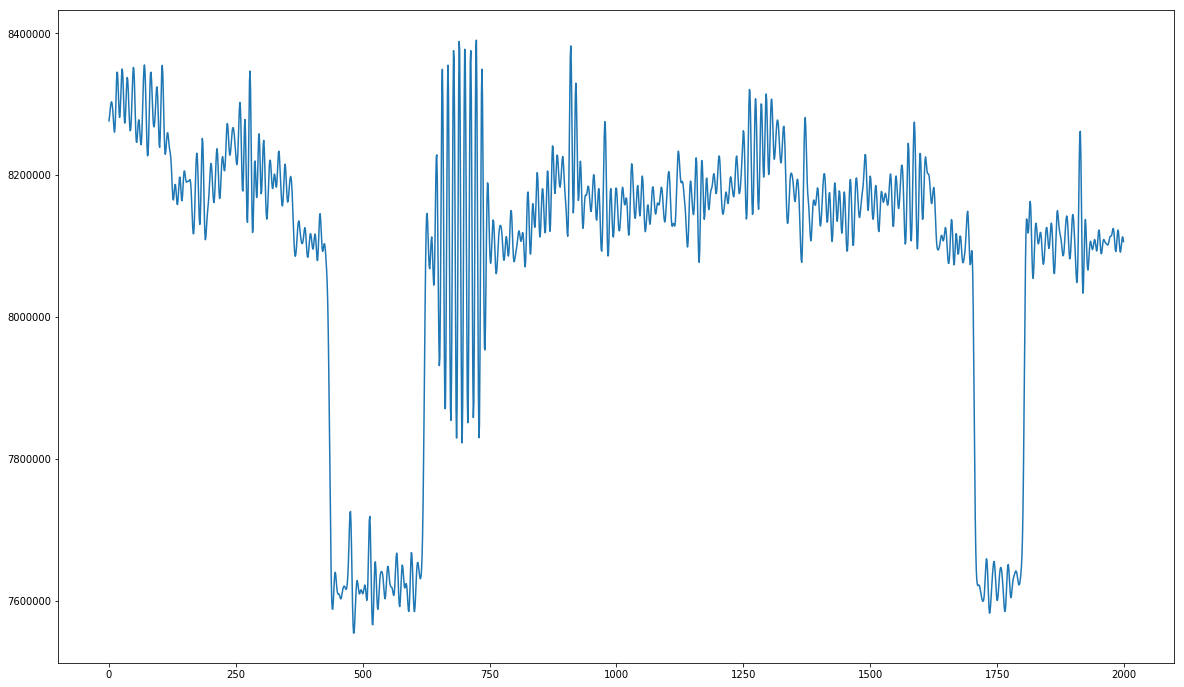

In [1025]:
plt.plot(output[37000:39000])

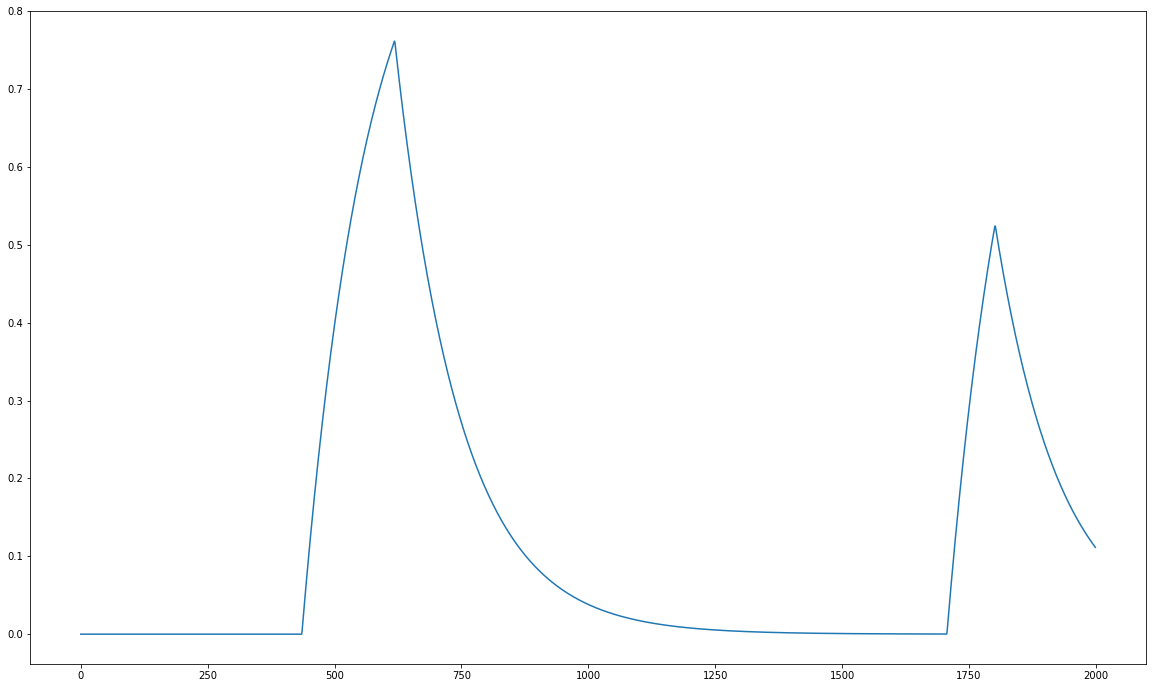

In [1026]:
plt.plot(output_syncf[37000:39000])

In [1004]:
for s in zip(*syncs1, *np.diff(syncs1)):
    print(s, output[s[0]], output_syncf[s[0]])
    

(1854, 2543) 7572177.34834 0.0935034938065
(4397, 2546) 7614476.27117 0.0935034691889
(6943, 2539) 7686511.44597 0.0997074949377
(9482, 2542) 7651563.42446 0.0935034691224
(12024, 2542) 7611669.59442 0.093503469283
(14566, 2543) 7613069.61871 0.093503469283
(17109, 2542) 7602741.30518 0.0935034692981
(19651, 2543) 7618315.61643 0.093503469283
(22194, 2543) 7633137.6954 0.0935034692339
(24737, 2542) 7615501.21499 0.0935034691702
(27279, 2542) 7634569.59244 0.0935034692187
(29821, 2542) 7639356.7337 0.0935034692187
(32363, 2543) 7631592.60869 0.0935034692187
(34906, 2542) 7607336.43527 0.0935034692339
(37448, 1271) 7627205.9822 0.0935034692314
(38719, 1272) 7605808.08016 0.0936378707716
(39991, 1271) 7636709.83671 0.0935495448638
(41262, 1270) 7626246.53496 0.093549213185
(42532, 1272) 7599209.64467 0.0935495739091
(43804, 1271) 7635203.63153 0.0935495408163
(45075, 1271) 7623831.70289 0.0935499041376
(46346, 8900) 7626013.33714 0.0935492132016
(55246, 1270) 7619363.73955 0.0935592282527

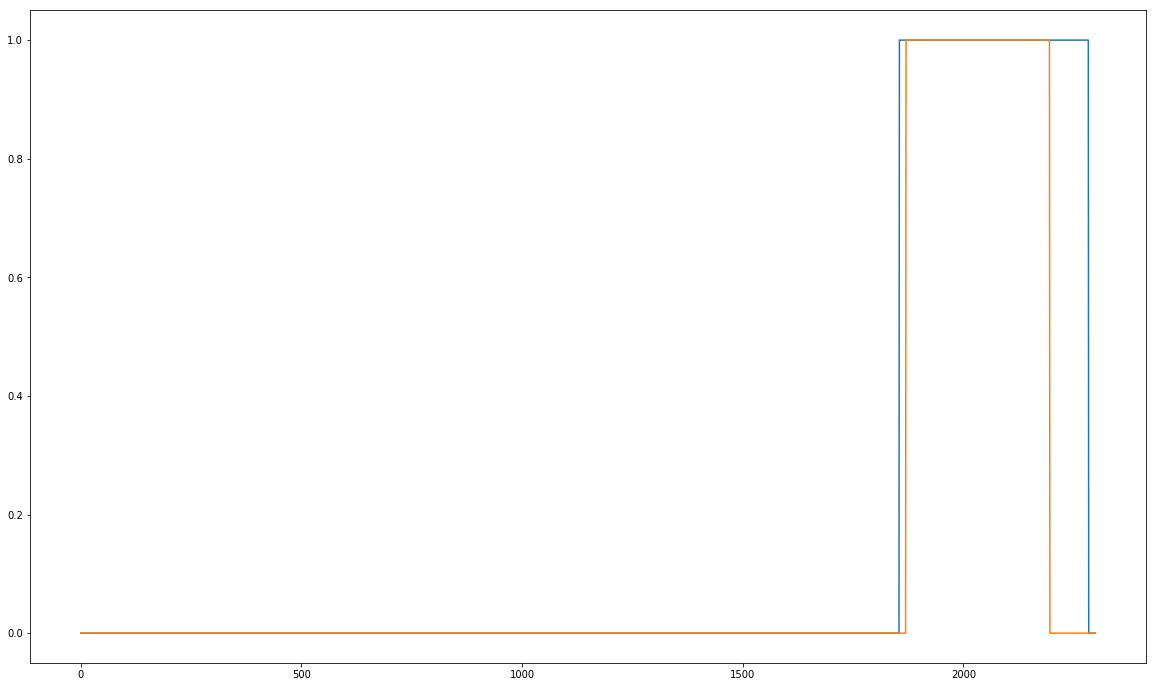

In [1010]:
plt.plot(output_syncf[0:2300] > .1)
plt.plot(output_syncf[0:2300] > .2)

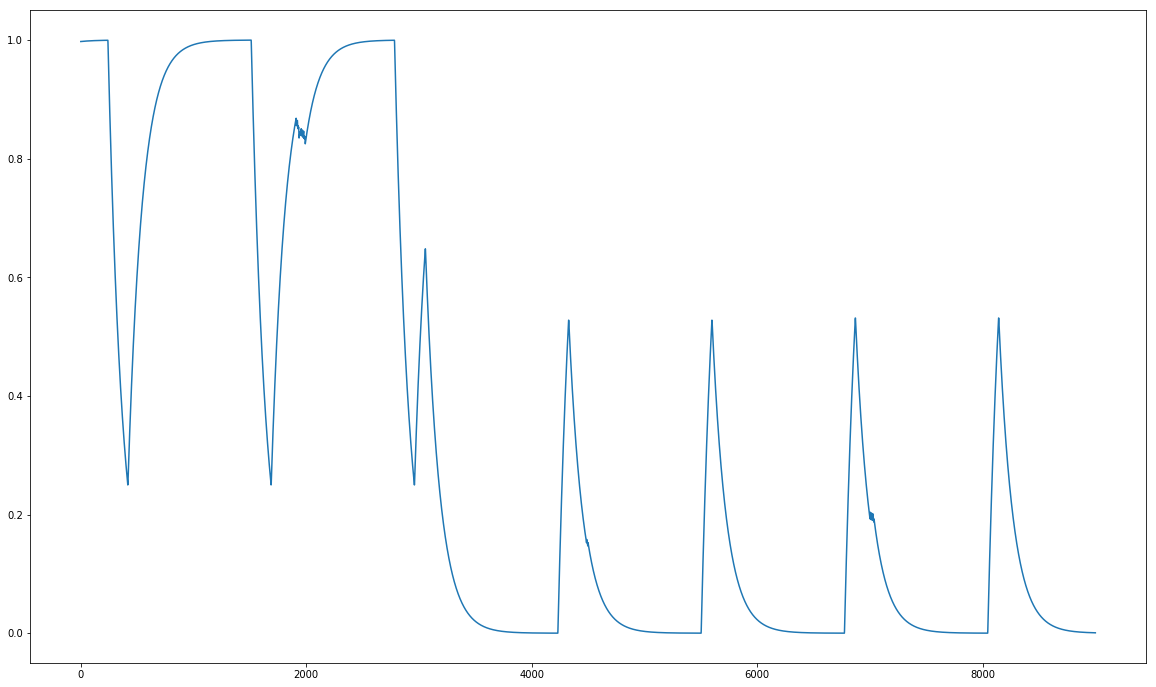

In [928]:
plt.plot(output_syncf[51000:60000])

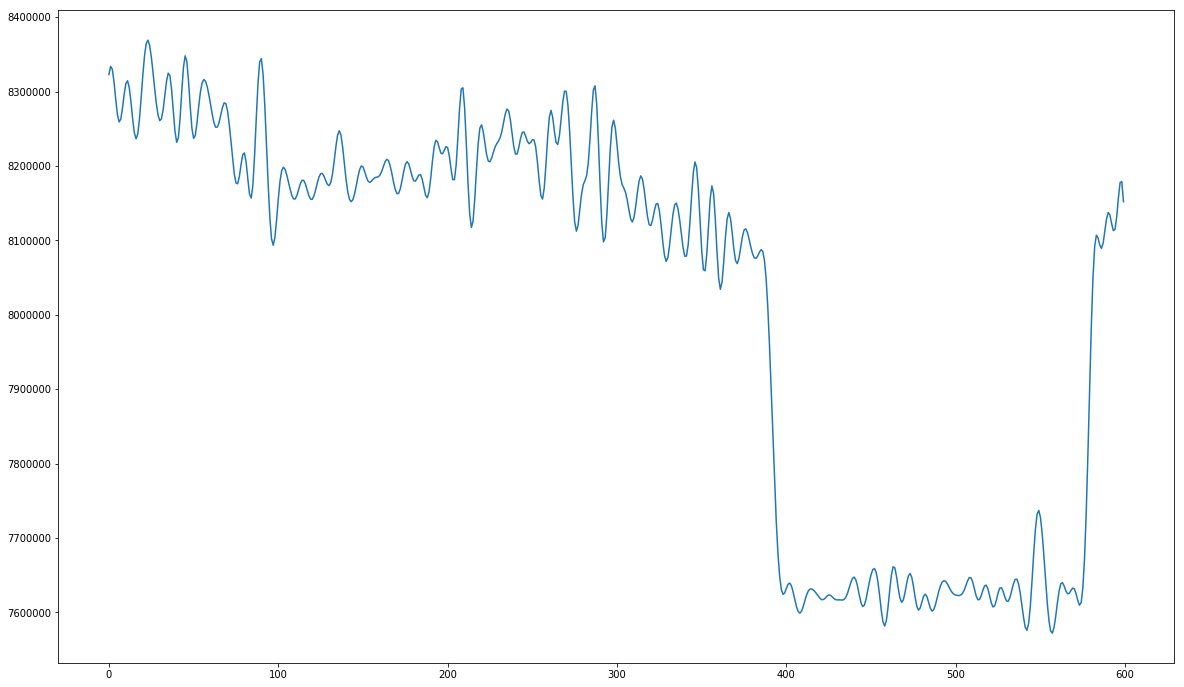

In [878]:
#plt.plot(output_syncf[35000:35100])
plt.plot(output[34500:35100])

In [821]:
np.max(output_syncf)

1.1084941670248452

In [848]:
np.argmax(output_syncf[0:8000])

4561

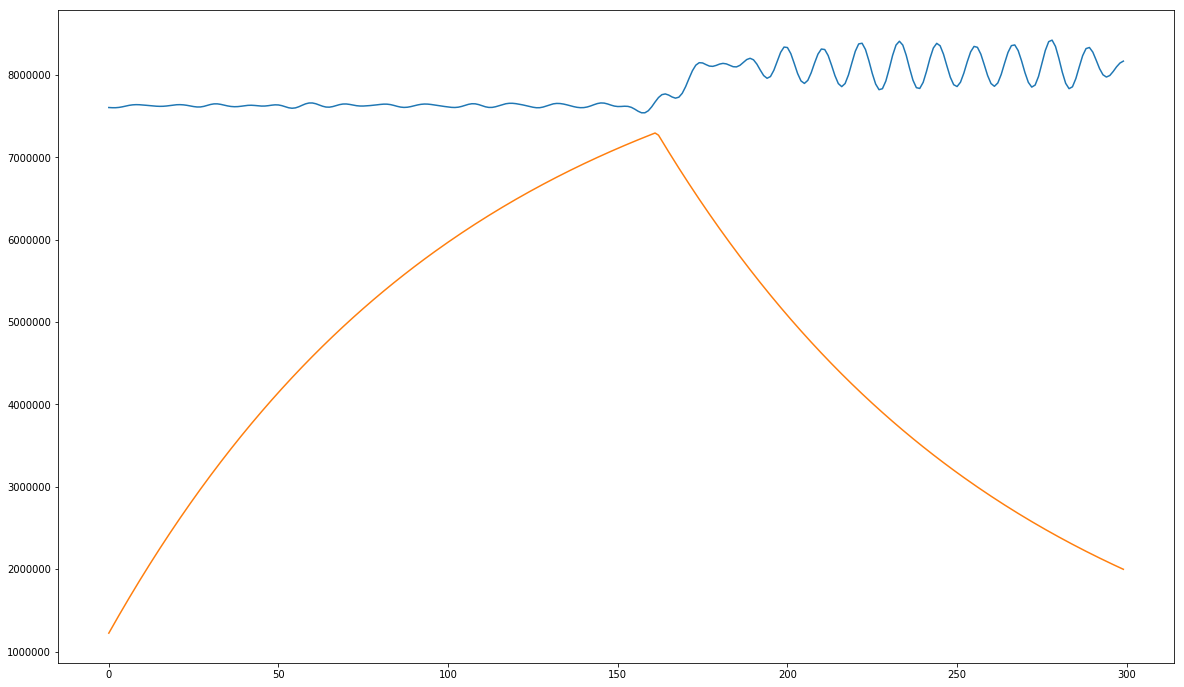

In [852]:
plt.plot(output[4400:4700])
plt.plot(output_syncf[4400:4700] * 9000000)

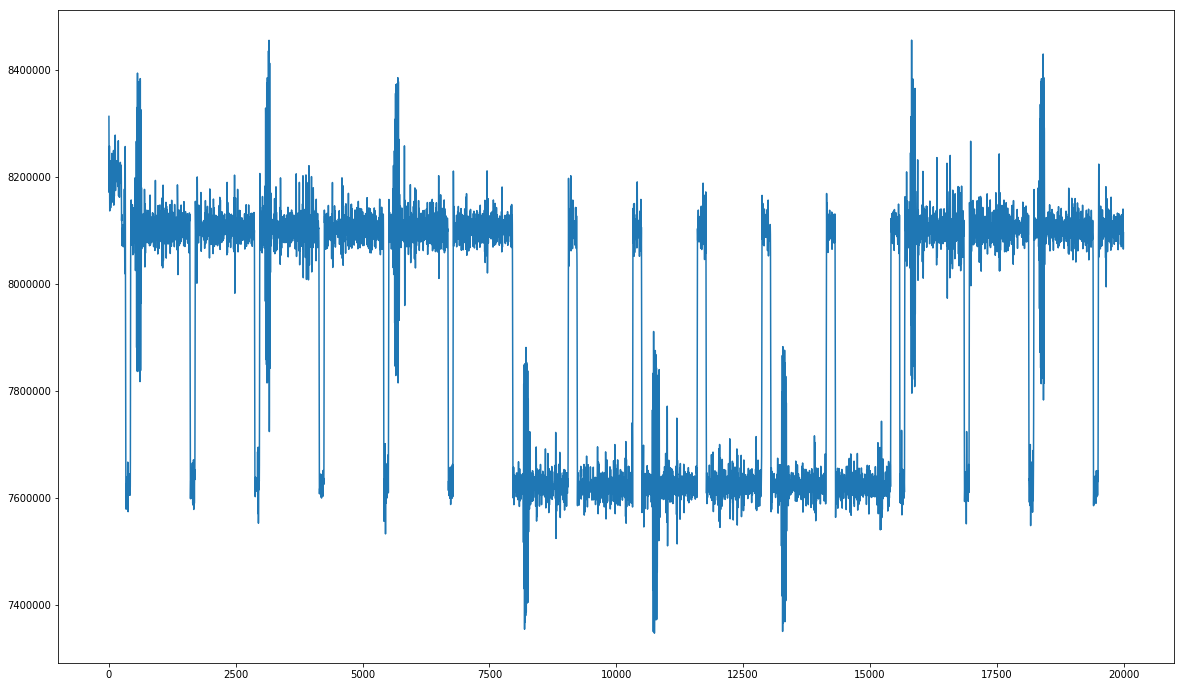

In [705]:
plt.plot(output1[190000:210000])

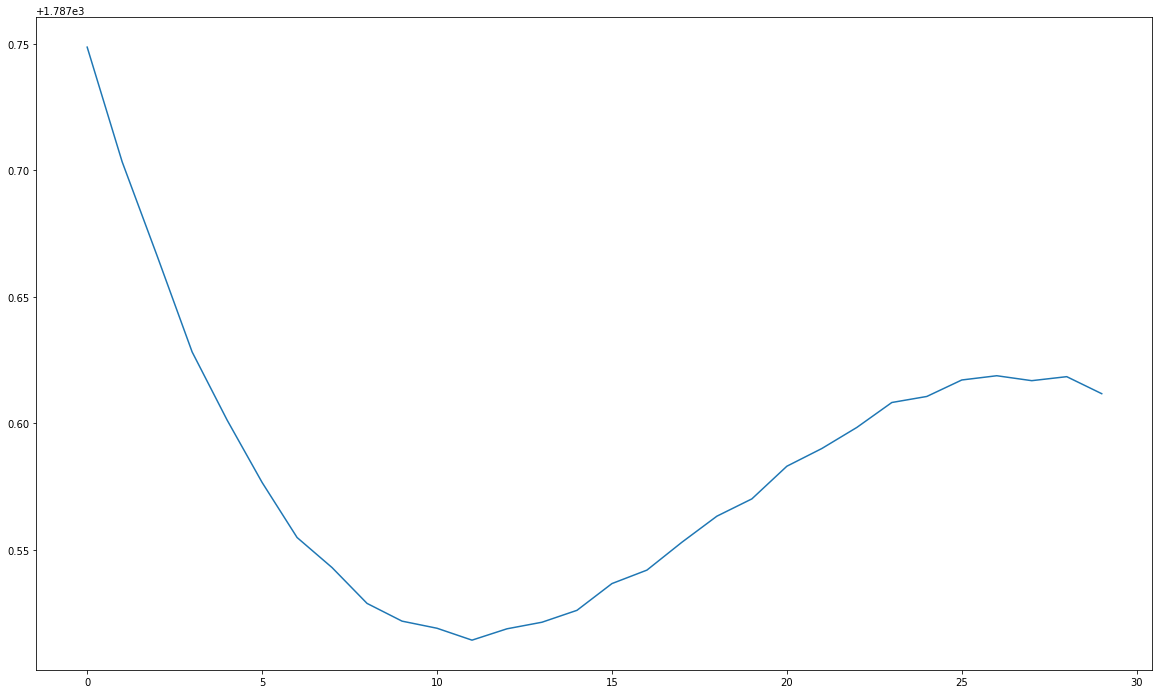

In [585]:
plt.plot(dsync2a[47340:47370])

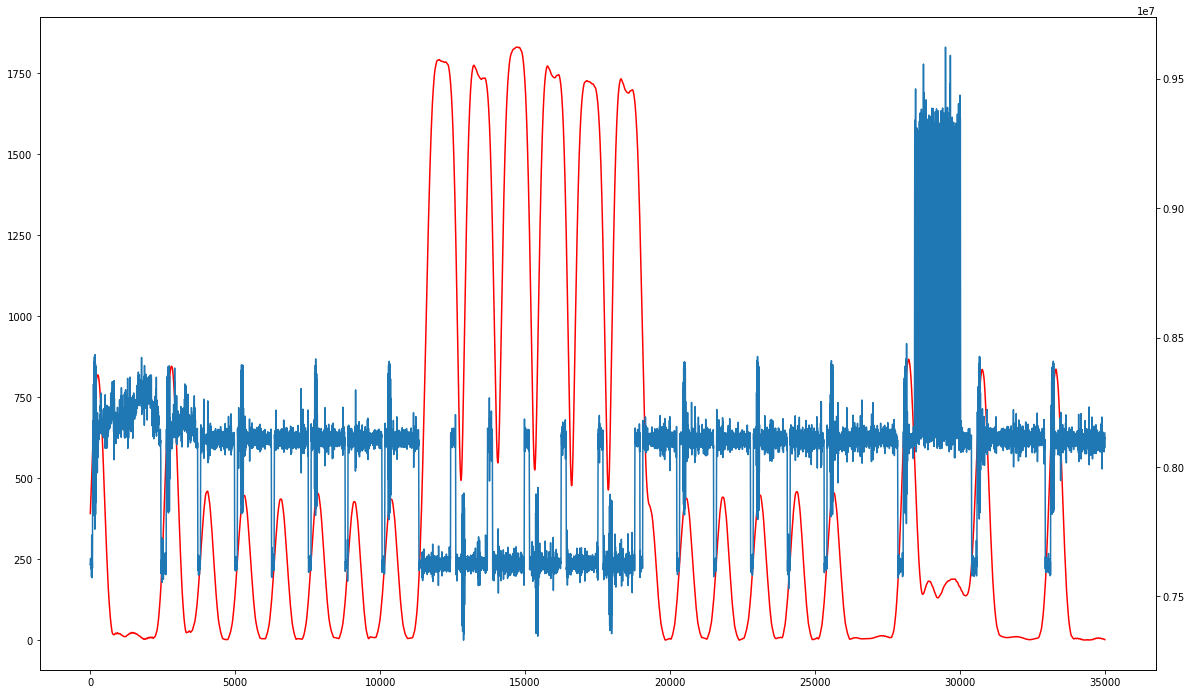

In [620]:
# Plot in different subplots
#fig, (ax1, ax2) = plt.subplots(1, 2)
fig = plt.figure()
ax1 = plt.subplot()
ax2 = plt.twinx()
ax1.plot(dsync2a[35000+256:70000+256], color='red')
ax2.plot(output[35000:70000])


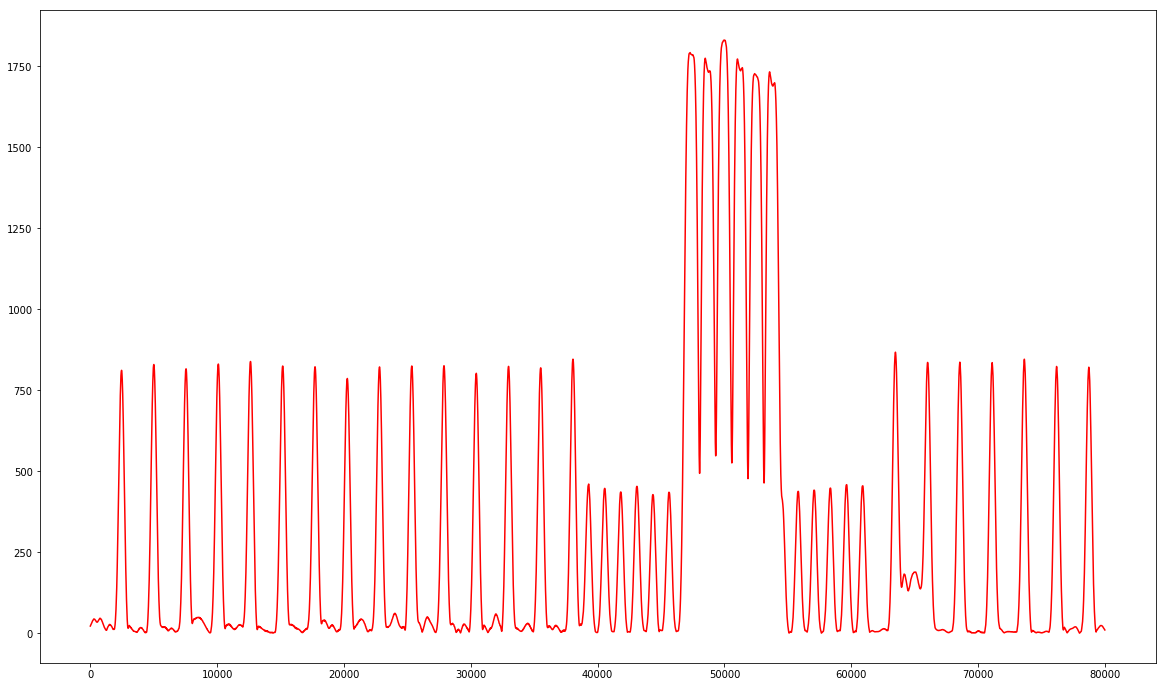

In [558]:
plt.plot(dsync2a[:80000], color='red')


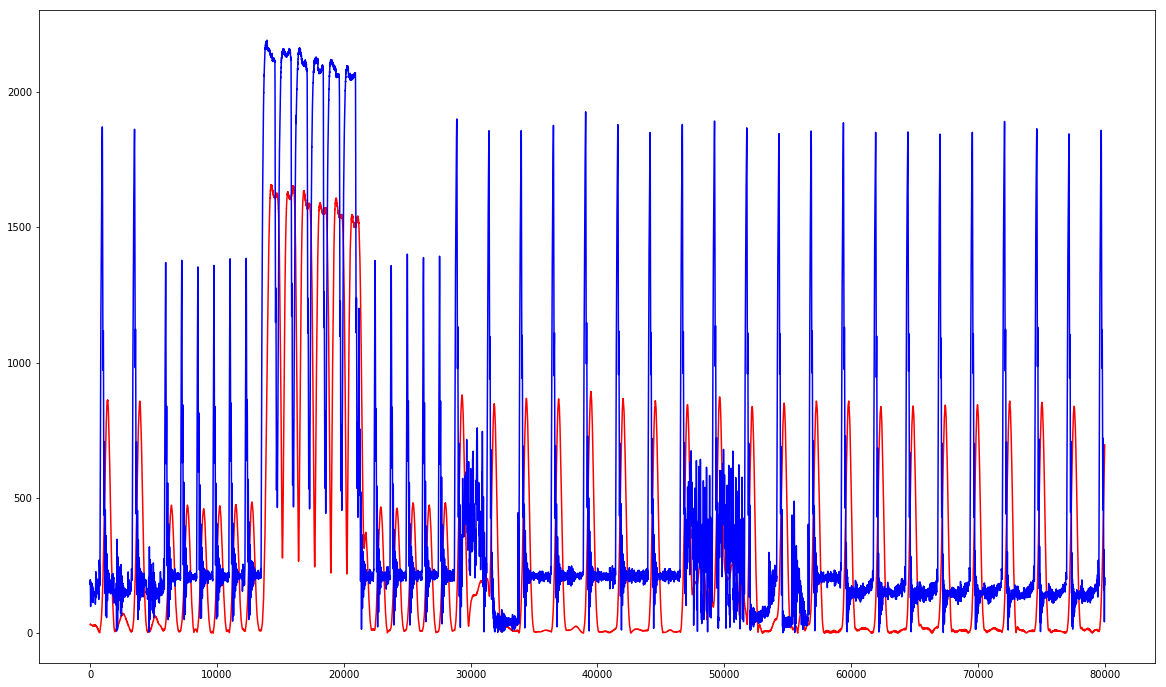

In [527]:
plt.plot(dsync2[700000:780000], color='red')
plt.plot(dsync[700000:780000], color='blue')

In [536]:
dsync2a = dsync2[0:50000]

In [546]:
np.where((dsync2a[:-1] > dsync2a[1:])[:-1] & (dsync2a[1:] > dsync2a[:-1])[1:])

(array([   22,    30,    37, ..., 49992, 49995, 49997]),)

In [553]:
np.argmax(dsync2[0:500000]), np.max(dsync2[0:500000])

(49960, 1831.9653415575606)

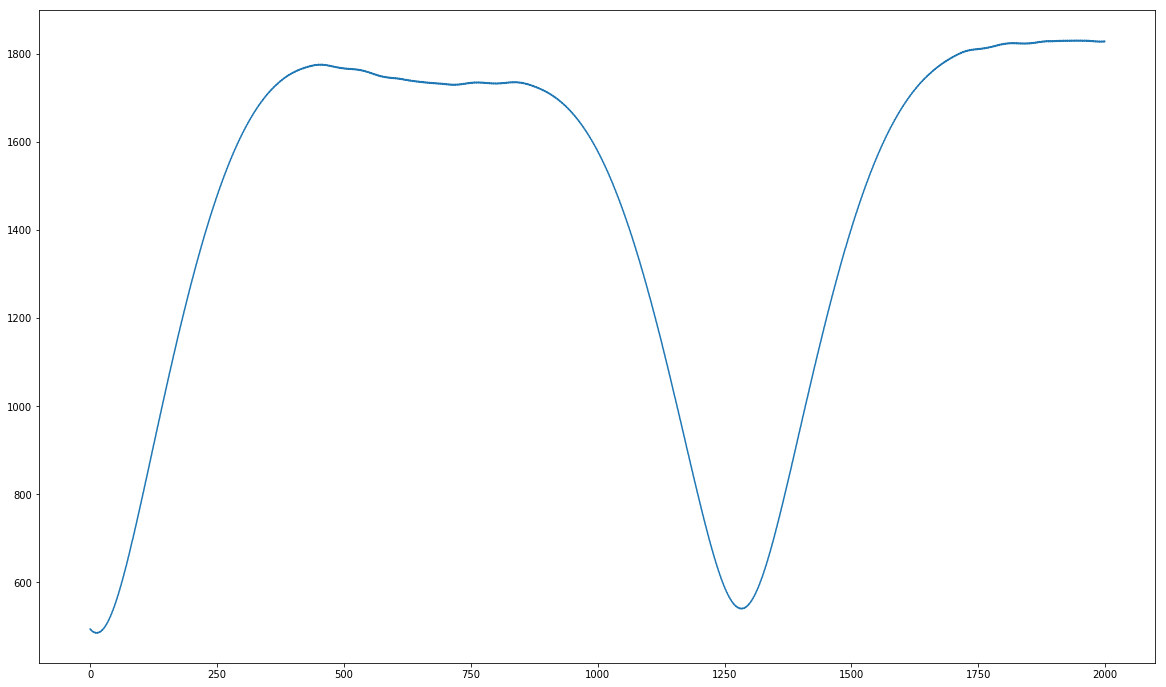

In [554]:
plt.plot(dsync2[48000:50000])

In [547]:
dsync2a[21:31]

array([ 28.2730465 ,  28.22621713,  28.16229576,  28.2034762 ,
        28.2339765 ,  28.1990089 ,  28.13172455,  27.93744449,
        27.74398476,  27.59240033])

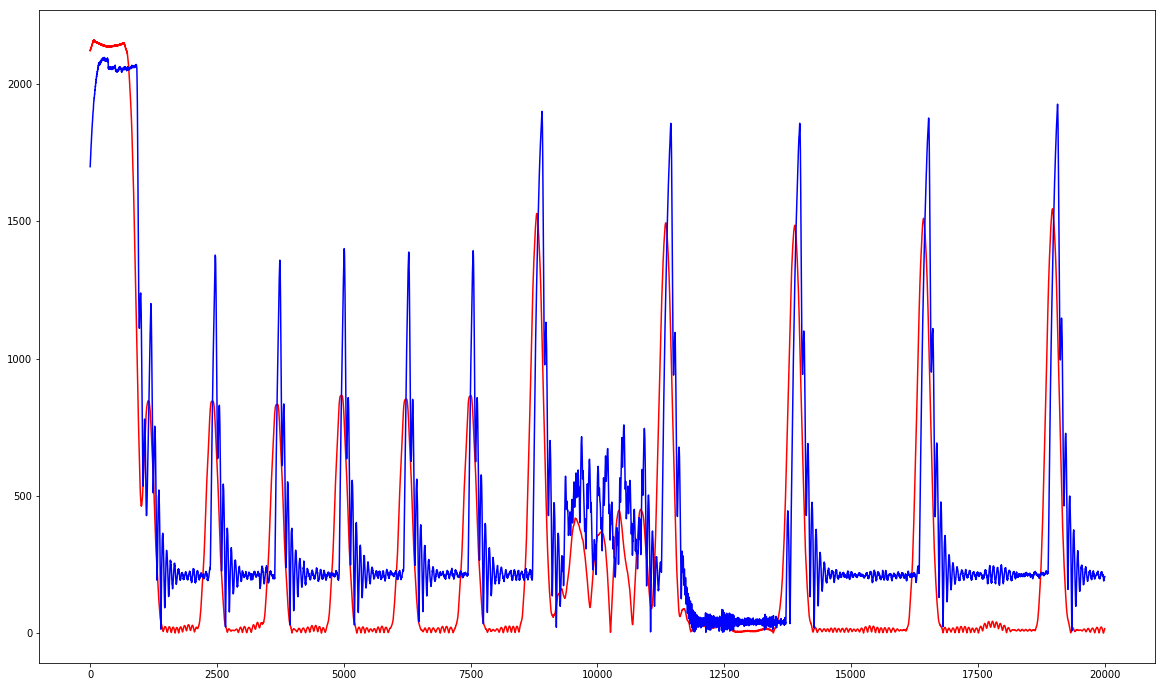

In [520]:
plt.plot(dsync2[720000+256:740000+256], color='red')
plt.plot(dsync[720000:740000], color='blue')

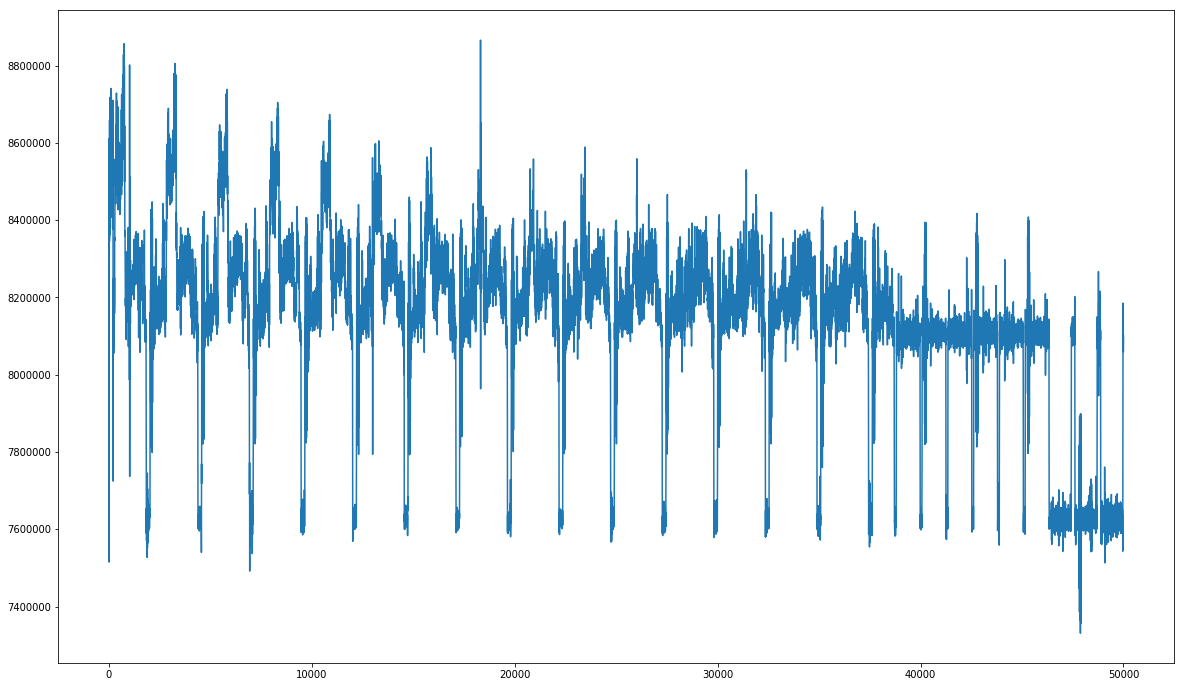

In [498]:
plt.plot(output[0:50000])

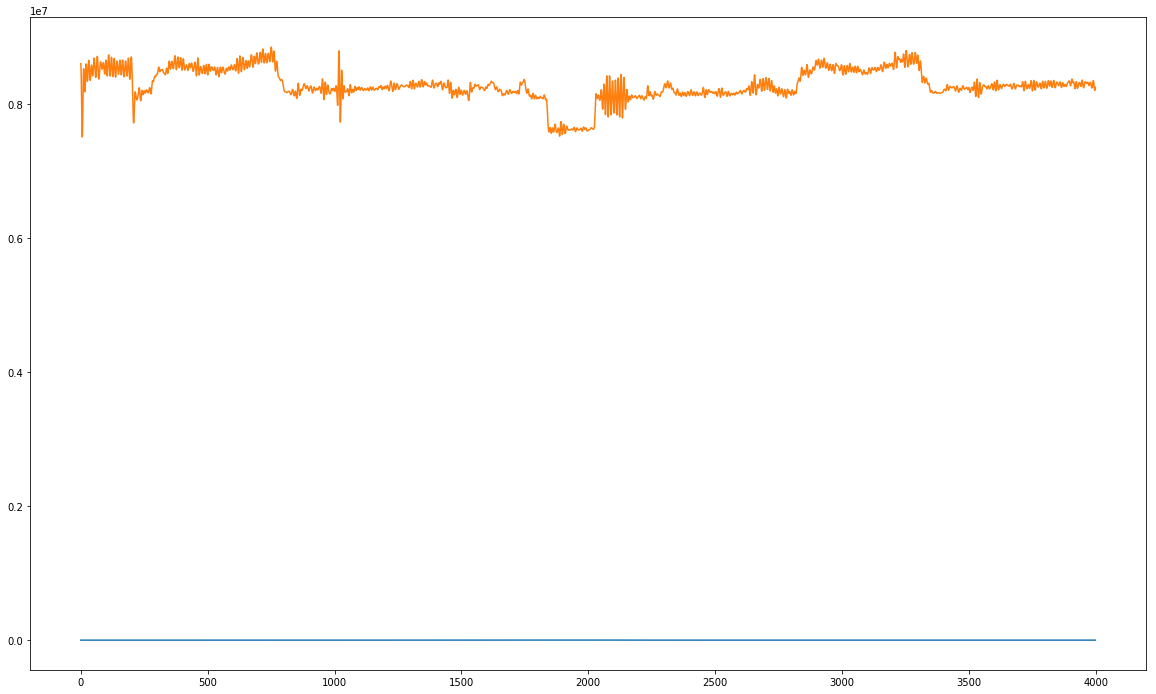

In [486]:
plt.plot(dsync[0+0:4000+0])
plt.plot(output[0:4000])

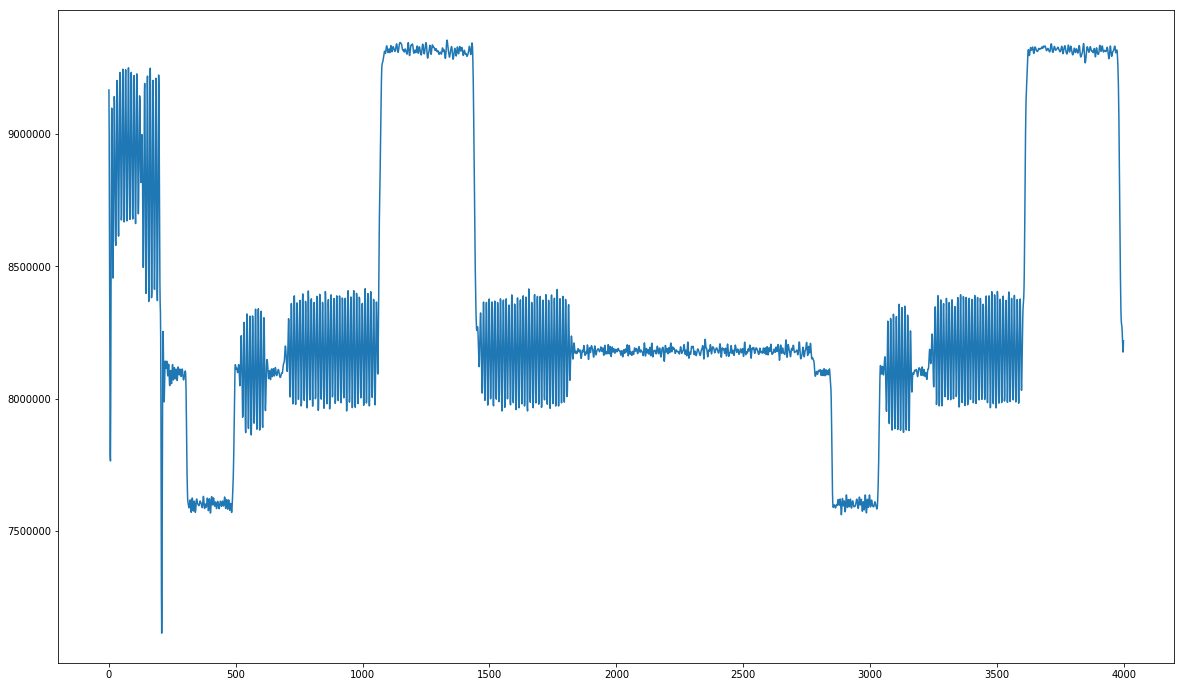

In [471]:
plt.plot(output[0:4000])

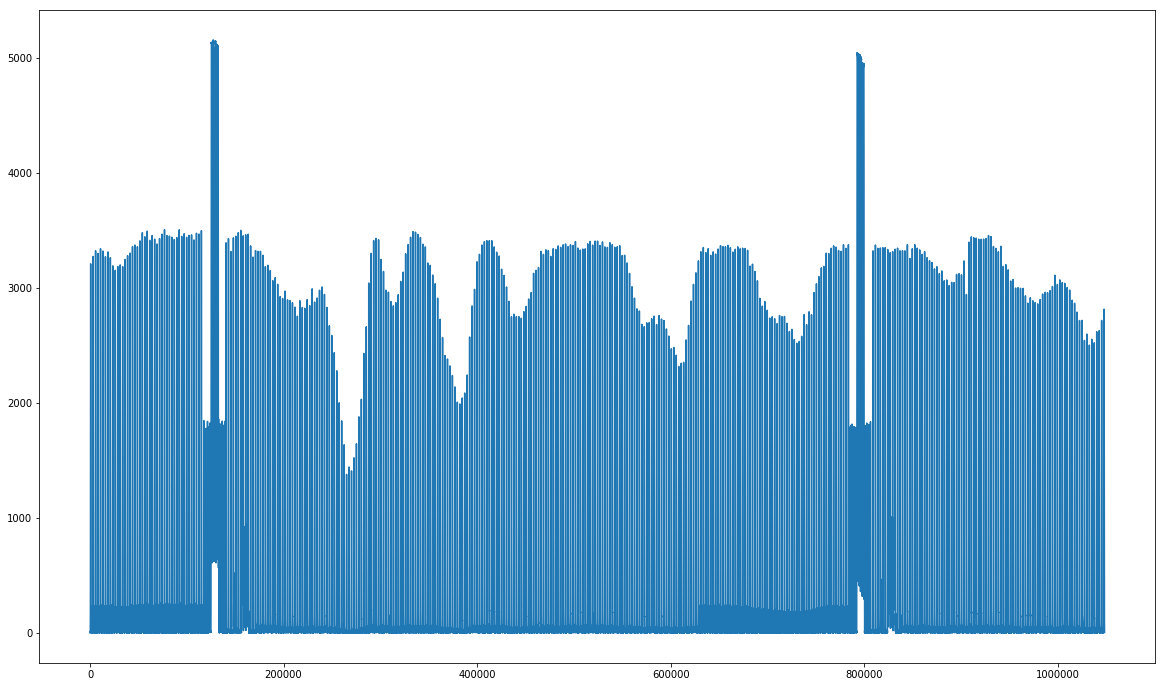

In [469]:
plt.plot(dsync2)

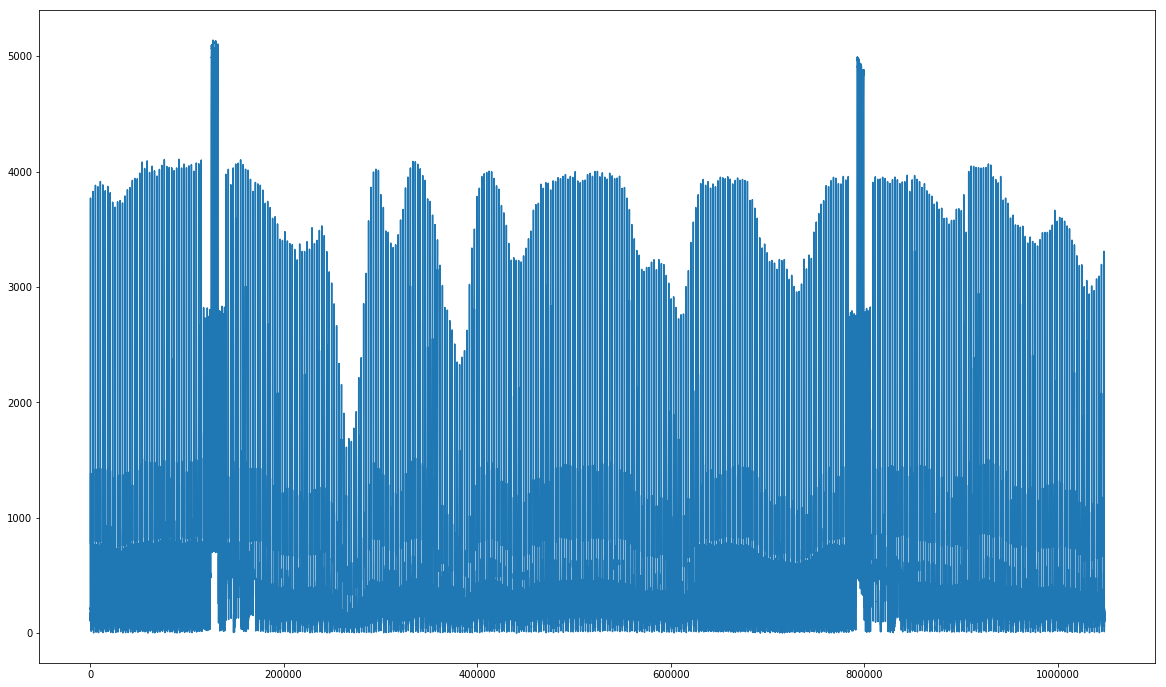

In [442]:
plt.plot(dsync)

In [423]:
dsync.imag

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

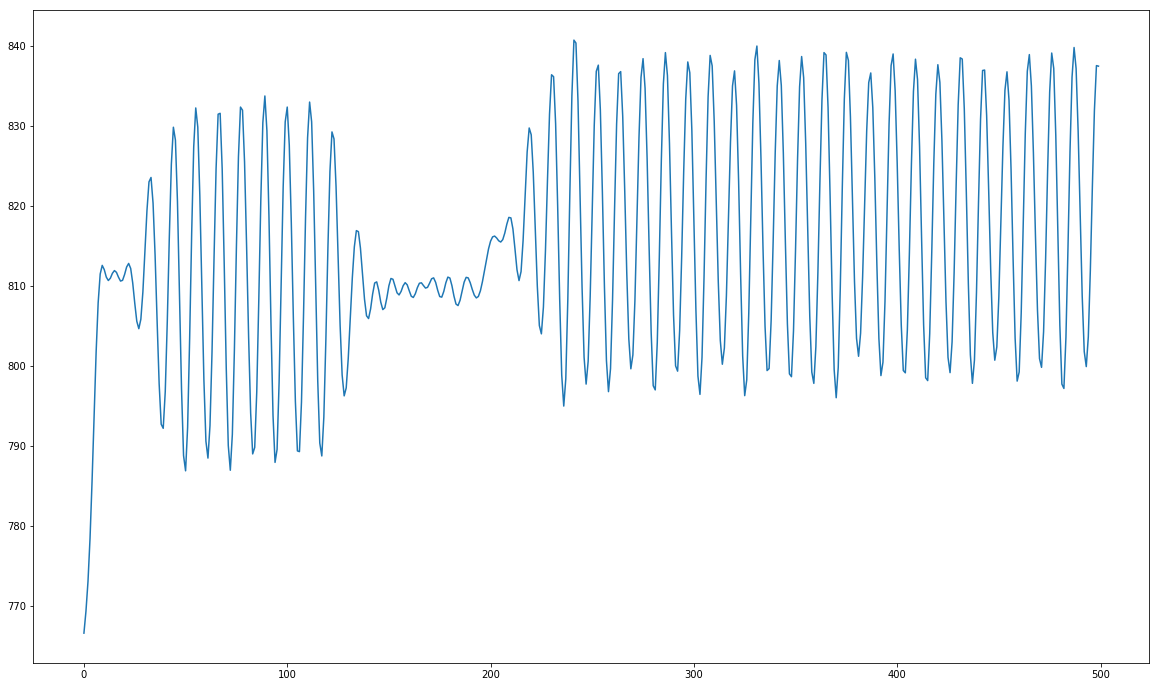

In [430]:
#plt.plot(d0[10000:13000])


idx = 5000 + dsync[5000:20000].argmax()
plt.plot(output[idx:idx+500] / 10**4)
#plt.plot(dsync[idx-100:idx+500])

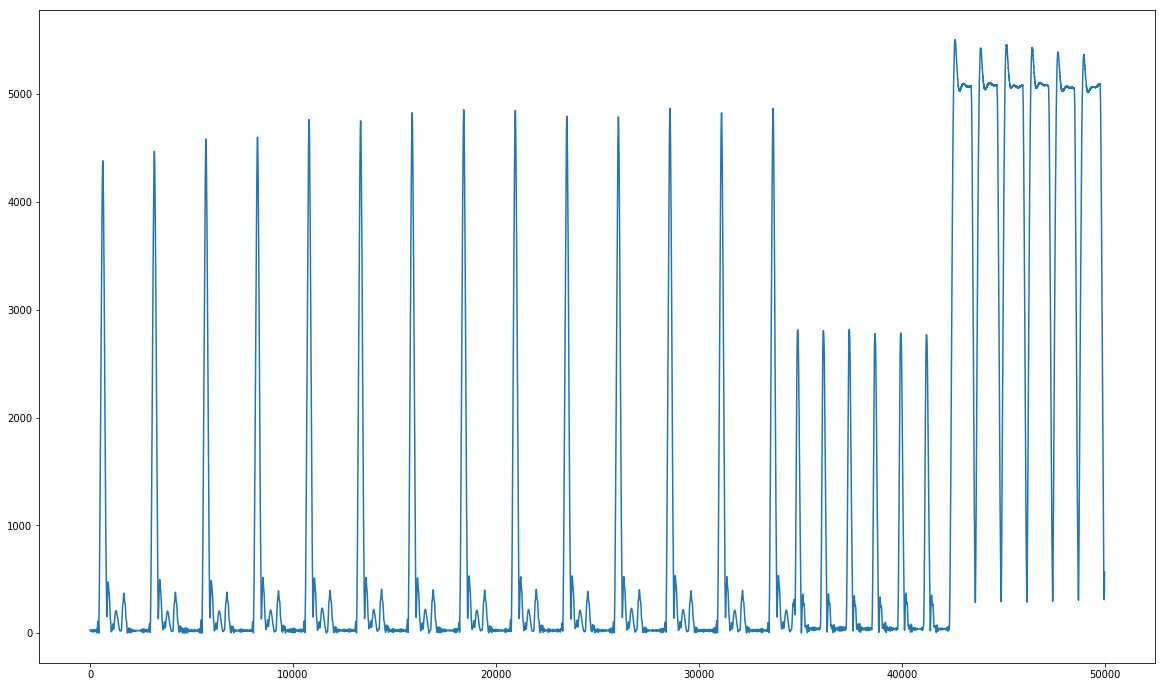

In [163]:
plt.plot(sqsum(dsync[750000:800000])5

In [358]:
freq_half = paramsc['freq'] / 2
cburst_filt = filtfft(sps.butter(1, [(paramsc['fsc_mhz'] - .5)/freq_half, (paramsc['fsc_mhz'] + .5)/freq_half], btype='bandpass'))

cburst_filta = sps.firwin(129, [(paramsc['fsc_mhz'] - .05)/freq_half, (paramsc['fsc_mhz'] + .05)/freq_half], pass_zero=False)
cburst_filta = sps.firwin(21, 2.5/freq_half, pass_zero=False)
cburst_filt = filtfft((cburst_filta, [1.0]))

cburst = np.fft.ifft(demod_fft * cburst_filt)

>-10db crossing at  2.32111150568
>-3db crossing at  2.43297230114
<-3db crossing at  2.71262428977


/home/cpage/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


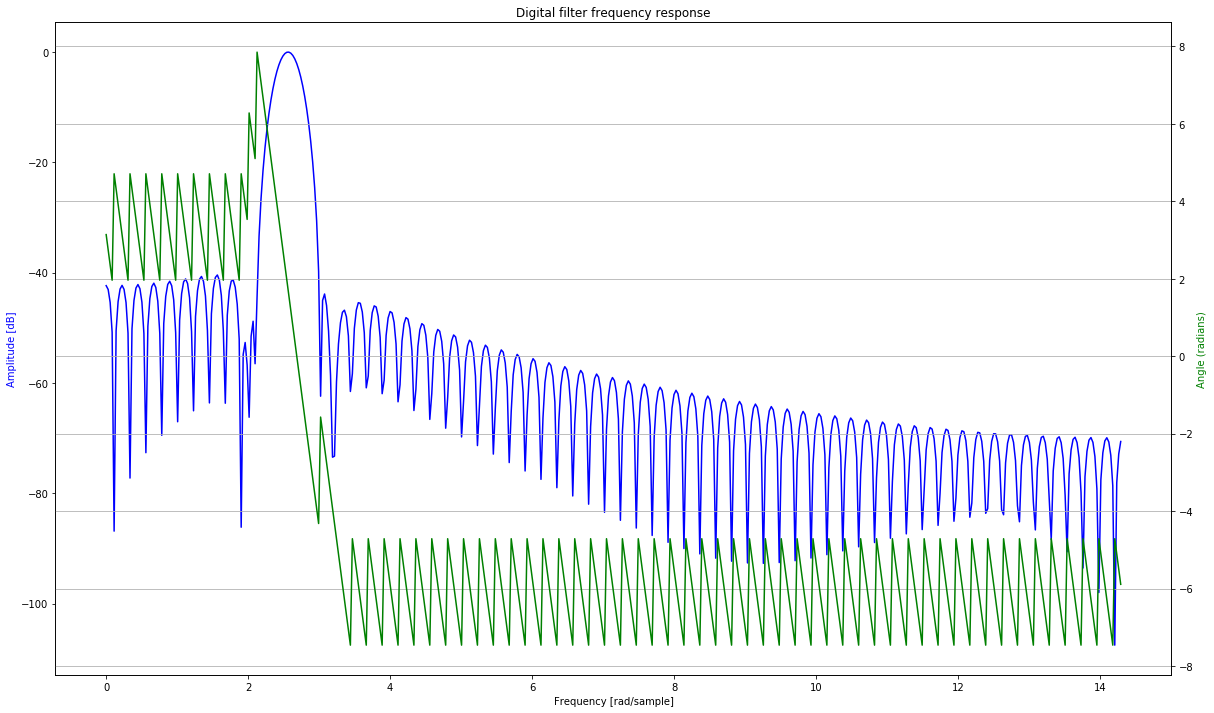

In [488]:
#warnings.warn(message, mplDeprecation, stacklevel=1)
doplot(cburst_filta, [1.0])

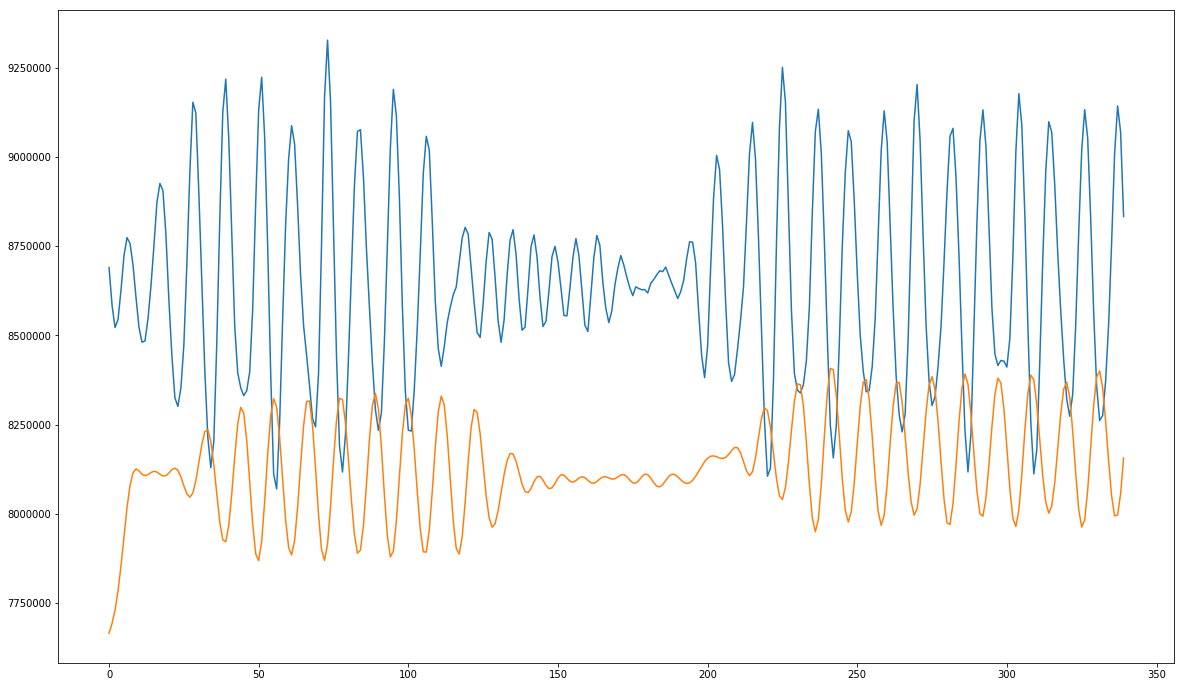

In [360]:
plt.plot((cburst[10660+20:11000+20].real) + 8100000)
plt.plot(output[10660:11000])

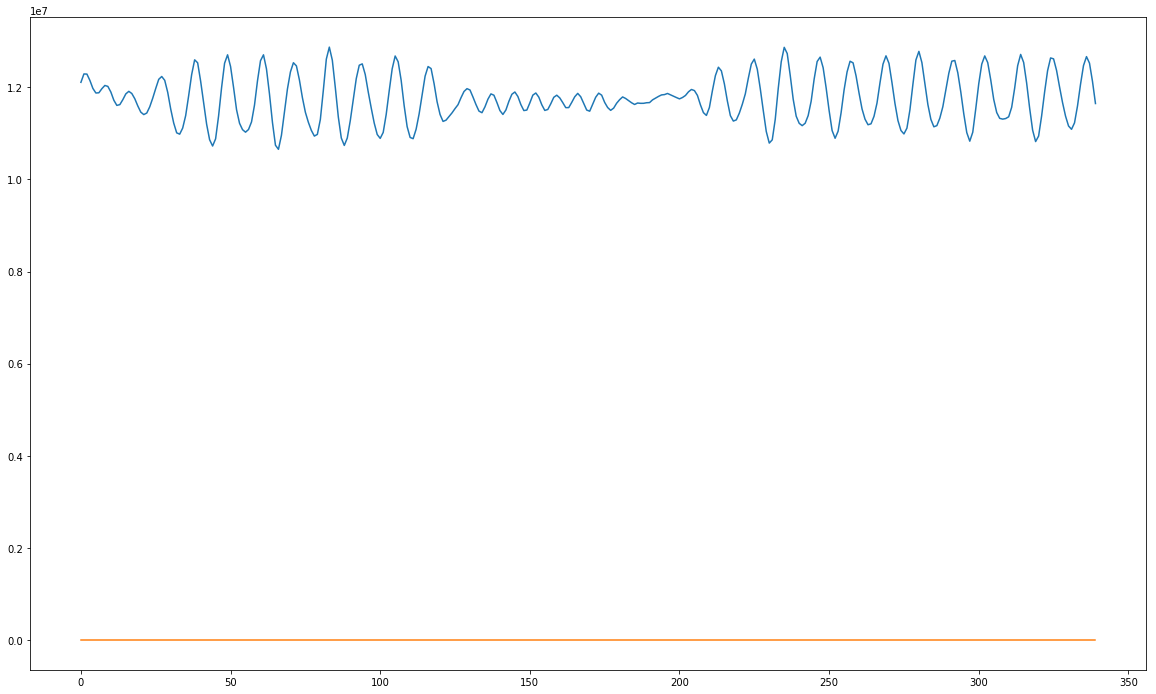

In [262]:
plt.plot(cburst[10660:11000].real)
plt.plot(cburst[10660:11000].imag)g

In [208]:
np.argmax(cburst[10660:11000])

94

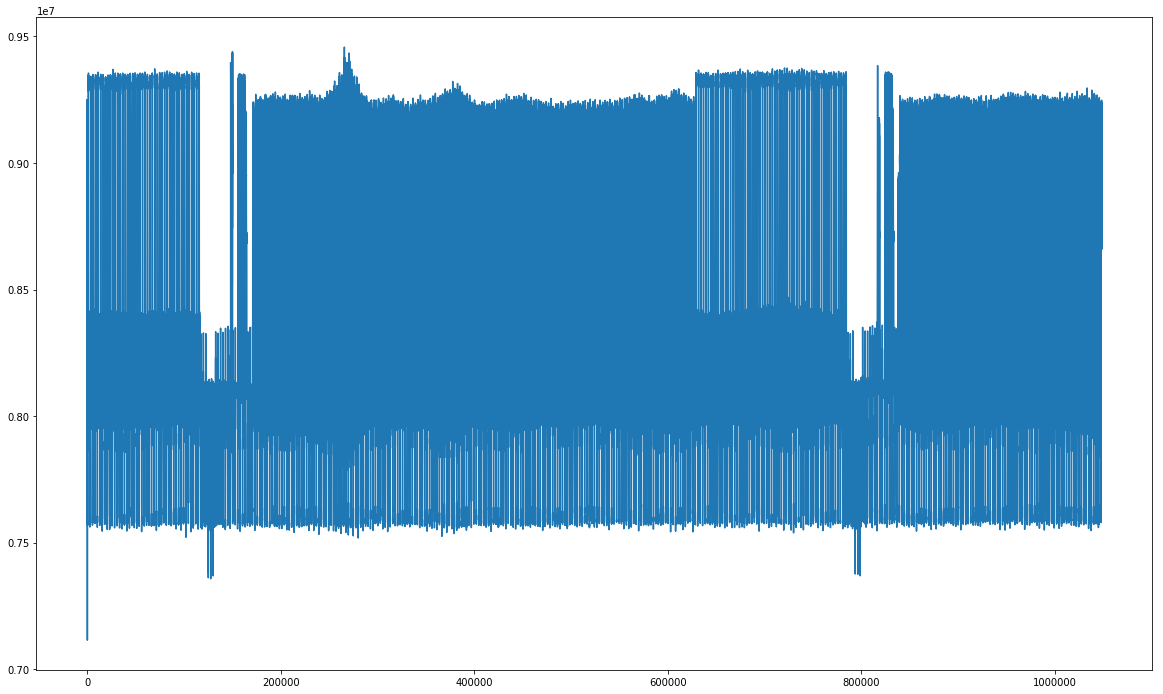

In [148]:
plt.plot(output)

In [ ]:
)